# Part 2: One-Dimensional Convolutional Neural Network (CNN) for Predictions of Intrinsic value of call and put option

After data-preprocessing, we have deepened our understanding of the dataset and the information contained in each column. Since our goal is to predict the intrinsic value of stocks, which by definition is a regression problem, we will use a one-dimensional Convolutional Neural Network (CNN) to predict the intrinsic value of call and put options. The predictions provide a good estimate of the intrinsic value of the options, which can be used as a reference for the amount of payoff that the options will provide.

## 2.1 Feature and Target Selection

The first step of our model building process is to select the features and target. We will use PyTorch to build the CNN model. PyTorch is a popular open-source machine learning library based on the Torch library, flexible and powerful for machine learning tasks. We will use the `torch` and `torchvision` libraries to build the CNN model.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 
import sqlite3
import math

After importing all the necessary libraries, we will load the preprocessed dataset from the database. By using the `sqlite3` library, we can connect to the database and load the dataset into a pandas dataframe. As shown below, we first create a cursor and use the SQL command to fetch the data from the database. We have two tables in the database, one for feature, and the other for target. 

In [2]:
# Read in the data from the database
conn = sqlite3.connect('tables.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
# Extract two tables from it and store them in two pd df
ds = pd.read_sql_query("SELECT * from df_2023_h1_feature", conn)
target = pd.read_sql_query("SELECT * from df_2023_h1_target", conn)

[('df_2023_h1_feature',), ('df_2023_h1_target',)]


We first take a look at the feature table named `ds`, and we make a copy of it for backup. As shown below, the feature table has a structure of 331609 rows × 22 columns, which has been preprossed in the previous section. We will then do feature selection from it. 

In [3]:
ds_new = ds.copy()
ds

,[QUOTE_UNIXTIME],[EXPIRE_UNIX],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],...,[C_ASK],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[P_BID],[P_ASK]
0,-1.69160,-1.531564,-1.054517,-2.406592,1.054125,-0.052714,0.000146,-0.391189,-0.307878,11.711458,...,0.676304,1.120791,-0.013192,0.001135,0.086874,0.592295,3.380989,-0.100406,-0.563368,-0.566211
1,-1.69160,-1.531564,-0.936052,-2.406592,1.041020,0.036229,0.000190,-0.390353,-0.308470,10.342762,...,0.479078,1.120350,-0.013031,0.001152,0.086843,0.592878,2.599981,-0.100406,-0.563368,-0.566211
2,-1.69160,-1.531564,-0.888665,-2.406592,1.035470,0.083539,0.000199,-0.393217,-0.308536,9.795964,...,0.400187,1.119196,-0.013111,0.001152,0.086442,0.592606,2.292638,-0.100406,-0.563368,-0.566211
3,-1.69160,-1.531564,-0.876819,-2.406592,1.048893,0.103725,0.000140,0.031159,-0.308217,9.553426,...,0.389734,1.120644,-0.013015,0.001157,0.086741,0.591011,2.214716,-0.100406,-0.563368,-0.566211
4,-1.69160,-1.531564,-0.864972,-2.406592,1.030873,0.108141,0.000225,-0.438792,-0.308574,9.529689,...,0.371195,1.119712,-0.013079,0.001120,0.086482,0.591167,2.139460,-0.100406,-0.563368,-0.566211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331604,1.78216,1.881977,0.367073,1.410238,-0.175447,0.125803,0.058474,0.064804,0.473889,-0.825637,...,-0.386156,-0.261286,0.003340,0.057390,0.064104,-2.657456,-0.483741,-0.100406,-0.191656,-0.130110
331605,1.78216,1.881977,0.426306,1.410238,-0.288188,0.141573,0.057498,0.121952,0.401497,-0.825637,...,-0.472936,-0.405104,0.004291,0.054827,0.067442,-2.681954,-0.504299,-0.100406,-0.142171,-0.085819
331606,1.78216,1.881977,0.485538,1.410238,-0.406236,0.147881,0.055627,0.179100,0.323910,-0.825637,...,-0.521651,-0.565709,0.005225,0.050409,0.071071,-2.573385,-0.528800,-0.100406,-0.090211,-0.033009
331607,1.78216,1.881977,0.544771,1.410238,-0.524528,0.142835,0.052804,0.249133,0.243663,-0.825637,...,-0.564252,-0.714509,0.005499,0.044680,0.074684,-2.371958,-0.536906,-0.100406,-0.024928,0.033049


Theen we take a glance at the target table with merely one column named "discounted_price". This column will be the target for our CNN model, as all feature engineering has been done in the data preprocessing phase.

In [4]:
target

,discounted_price
0,-63.916774
1,-54.101350
2,-50.175181
3,-49.193639
4,-48.212096
...,...
331604,-18.619560
331605,-13.711848
331606,-8.804136
331607,-3.896425


For the feature and target selections, we first concatenate the feature and target tables together. 

In [5]:
# Merge target and ds directly, as they match and have the same length
ds_new = pd.concat([ds_new, target], axis=1)

In [6]:
ds_new.columns

Index(['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]', '[STRIKE]', '[UNDERLYING_LAST]',
       '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', '[C_IV]',
       '[C_VOLUME]', '[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]',
       '[P_VEGA]', '[P_THETA]', '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]',
       '[P_ASK]', 'discounted_price'],
      dtype='object')

In [7]:
# # Add new cols for the target, namely -rt and price diff
# ds_new['-rt'] = -0.04*(ds['[EXPIRE_UNIX]'] - ds['[QUOTE_UNIXTIME]'])/(3600*365*24)
# ds_new['price_diff'] = ds_new['[STRIKE]'] - ds_new['discounted_price']
# ds_new['-rt'] = pd.to_numeric(ds_new['-rt'])
# ds_new['exp(-rt)'] = ds_new['-rt'].apply(lambda x: math.exp(x))
# ds_new = ds_new.loc[:, ~ds_new.columns.str.contains('^Unnamed')]  
# ds = ds.loc[:, ~ds.columns.str.contains('^Unnamed')]

We finalize the features and target_1 as our final features and target for the 1D CNN model. We select all option greeks for call and put as well as the quote and expire dates for features; and we multiply the "price_diff" by the exp(-rt) to get the target_1.

In [8]:
features = ds_new[['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]', '[STRIKE]', '[UNDERLYING_LAST]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
       '[C_THETA]', '[C_RHO]', '[C_IV]', '[C_VOLUME]','[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]',
       '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]', '[P_ASK]']].values
target_1= ds_new['discounted_price']

## 2.2 Train, Validation, and Test Data Split

After feature engineering, we now do the train, validation, and test data split. We will directly use slicing to create the three datasets but not sklearn's train_test_split function, because each expire date has multiple strike prices, so we need to ensure the integrity of each expire date's information. The proportion of the train, validation, and test datasets is 0.8, 0.1, and 0.1, respectively. We will use the first 80% of the data for training, the next 10% for validation, and the last 10% for testing.

In [9]:
# Manually using slicing to create the train, validation and test dataset in percentage of 80, 10, 10
X_train = features[:int(0.8*len(features))]
X_val = features[int(0.8*len(features)):int(0.9*len(features))]
X_test = features[int(0.9*len(features)):]
y_train = target_1[:int(0.8*len(target_1))]
y_val = target_1[int(0.8*len(target_1)):int(0.9*len(target_1))]
y_test = target_1[int(0.9*len(target_1)):]


Then we convert these datasets to PyTorch tensors, and then we print out the shapes of the three datasets to ensure that the data split is successful.

In [10]:
# Convert the data to tensor
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_val = torch.from_numpy(X_val).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train.values).type(torch.Tensor)
y_val = torch.from_numpy(y_val.values).type(torch.Tensor)
y_test = torch.from_numpy(y_test.values).type(torch.Tensor)

In [11]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: torch.Size([265287, 22]) torch.Size([265287])
Validation shapes: torch.Size([33161, 22]) torch.Size([33161])
Test shapes: torch.Size([33161, 22]) torch.Size([33161])


We need to do some unsqueeze operations to make the data suitable for the CNN model. The CNN model requires the input to be in the shape of (batch_size, channels, sequence_length), so we need to unsqueeze the second dimension of the input data to make it suitable for the CNN model.

In [12]:
X_train = X_train.unsqueeze(2)
print(X_train.shape)
X_val = X_val.unsqueeze(2)
print(X_val.shape)
X_test = X_test.unsqueeze(2)
print(X_test.shape)

torch.Size([265287, 22, 1])
torch.Size([33161, 22, 1])
torch.Size([33161, 22, 1])


## 2.3 1D CNN Model Construction

As all the data is ready, we now construct the 1D CNN Model for the intrinsic value prediction. Before building the class of the model, we first import all torch related libraries and then define the model, including the torch.nn.functional library.

In [13]:
import torch
from torch import nn
import torch.nn.functional as F

In order to ensure the robustness and generalization of the model, the CNN we create has the following structure:

1. **Initial Convolution Block:**

   - Conv1d: 22 input channels, 64 output channels, kernel size=3, stride=1, padding=1
   - BatchNorm1d: 64 features (output channels)
- ***Interpretation: The initial convolution block is used to extract the features from the input data, and the batch normalization layer is used to normalize the features to ensure that the features are in the same scale.***
2. **Residual Chunk 1:**

   - Conv1d: 64 input channels, 64 output channels, kernel size=3, padding=1
   - BatchNorm1d: 64 features
   - Conv1d: 64 input channels, 64 output channels, kernel size=3, padding=1
   - BatchNorm1d: 64 features
   - *Note:* Residual connection adds the input of the chunk to its output after these layers.
- ***Interpretation: The first residual chunk preserves the number of channels at 64 but allows the model to learn an identity function easily, ensuring the layer can improve performance without hurting existing capabilities.***
3. **Residual Chunk 2:**

   - Conv1d: 64 input channels, 128 output channels, kernel size=3, padding=1, stride=2
   - BatchNorm1d: 128 features
   - Conv1d: 128 input channels, 128 output channels, kernel size=3, padding=1
   - BatchNorm1d: 128 features
   - Shortcut Connection (for residual addition):
     - Conv1d: 64 input channels, 128 output channels, kernel size=1, stride=2
- ***Interpretation: The second residual chunk includes a shortcut connection with a 1D convolutional layer (`self.res2_shortcut`) to match the dimensionality change for the residual connection.***
4. **Dropout Layer:**

   - Dropout: 0.3 probability.
   - ***Interpretation: The dropout layer is pplied to reduce overfitting by randomly setting input elements to zero during training with a probability of 0.3 (`self.dropout`).***
5. **Adaptive Pooling and Fully Connected Layers:**

   - AdaptiveAvgPool1d: Output size of 1
   - Linear FC layer: 128 input features, 128 output features
   - Dropout: 0.3 probability
   - Linear FC layer: 128 input features, 128 output features
   - Dropout: 0.3 probability
   - Linear FC layer: 128 input features, 128 output features
   - Dropout: 0.3 probability
   - Linear FC layer: 128 input features, 1 output feature
- ***Interpretation: The adaptive pooling layer is used to output a fixed-length output irrespective of input size, facilitating the connection to fully connected layers. The linear fully connected layers with dropoutapplied between them help to further prevent overfitting. The last fully connected layer reduces the output to 1 dimension.***

And the visualization of the model structure is shown below:
![1D CNN Structure Diagram](Conv1D.png)

We then import the python file CNN_CODE.py to access the CNN class and all necessary code, and then inspect to use them. 

In [14]:
from CNN_CODE import Convolution1D
import inspect
print(inspect.getsource(Convolution1D))

class Convolution1D(nn.Module):
    def __init__(self):
        '''
        Convolutional Neural Network with 1D convolutions
        params:
        - input_channels: number of input channels
        - output_channels: number of output channels
        - kernel_size: size of the kernel
        - stride: stride of the kernel
        - padding: padding of the kernel
        '''
        super(Convolution1D, self).__init__()
        
        # Initial Convolution
        # 22 input channels (features), 64 output channels, 3x3 kernel
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Batch Normalization with 64 features
        self.bninit = nn.BatchNorm1d(64)

        # Residual chunk 1
        self.res1_conv1 = nn.Conv1d(64, 64, 3, padding=1)
        self.res1_bn1 = nn.BatchNorm1d(64)
        self.res1_conv2 = nn.Conv1d(64, 64, 3, padding=1)
        self.res1_bn2 = nn.BatchNorm1d(64)
        
        # Residual chunk 2
        se

## 2.4 Model Training and Validation

As we constructed our CNN model, we now train and validate the model. We first define the loss function and the optimizer, using the Mean Squared Error (MSE) loss function to calculate the loss and the Adam optimizer to optimize the model. We set the learning rate as 0.01 and the weight decay as 0.0001. We also set various hyperparameters, including the number of epochs and the device to train the model. We set the number of epochs to 100 and the device to "cuda" if it is available; otherwise, we use "cpu".

Also, for preventing early stopping, we use the `patience` parameter to set the number of epochs to wait for improvement before stopping the training process. We set the `patience` to 15, which means that if the validation loss does not improve for 15 epochs, the training process will stop. We also set the L2 regularization to 0.0001 to prevent overfitting.

Then, we create a loop to train and validate the model. We first set the model to training mode and then iterate through the training dataset, then compute the loss and update the model parameters using the optimizer, with the backward propagation.

After this, we set the model to evaluation mode and iterate through the validation dataset to calculate the validation loss. We also print out the training and validation loss for each epoch to monitor the training process. Should the early stopping condition is met, we use `torch.save` to save the model and stop the training process. The training and validation loss of each epoch are stored, and they are printed as below.

In [15]:
from torch import optim

model = Convolution1D()
val_loss_list, train_loss_list =[],[]
final_epoch = 0
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# For early stopping
patience = 15
optimal_val_loss = np.inf
current_patience = 0
# Training phase
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze(-1)
    assert outputs.shape == y_train.shape, f"Shape mismatch: outputs {outputs.shape}, target {y_train.shape}"
    loss = criterion(outputs, y_train)
    train_loss_list.append(loss)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val).squeeze(-1)
        val_loss = criterion(val_outputs, y_val)
        val_loss_list.append(val_loss)
        # Early stopping
        if val_loss < optimal_val_loss:
            optimal_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            current_patience = 0
        else:
            current_patience += 1
            if current_patience == patience:
                print(f'Early stopping at epoch {epoch+1}')
                final_epoch = epoch
                # load best model
                model.load_state_dict(torch.load('best_model.pt'))
                break
    
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch [1/100], Loss: 9172.8681640625, Val Loss: 1818.197265625
Epoch [2/100], Loss: 9102.5693359375, Val Loss: 1751.77685546875
Epoch [3/100], Loss: 8275.830078125, Val Loss: 1398.82080078125
Epoch [4/100], Loss: 5244.42724609375, Val Loss: 681.4796752929688
Epoch [5/100], Loss: 7110.5087890625, Val Loss: 1006.462890625
Epoch [6/100], Loss: 3426.317626953125, Val Loss: 1126.9154052734375
Epoch [7/100], Loss: 4286.83154296875, Val Loss: 938.3817749023438
Epoch [8/100], Loss: 4022.037109375, Val Loss: 682.0269165039062
Epoch [9/100], Loss: 3196.9482421875, Val Loss: 917.9542236328125
Epoch [10/100], Loss: 3701.21533203125, Val Loss: 181.23085021972656
Epoch [11/100], Loss: 1524.900634765625, Val Loss: 389.5296936035156
Epoch [12/100], Loss: 1103.0982666015625, Val Loss: 1594.5777587890625
Epoch [13/100], Loss: 1861.9698486328125, Val Loss: 2287.84619140625
Epoch [14/100], Loss: 2340.36279296875, Val Loss: 1141.52294921875
Epoch [15/100], Loss: 1081.2857666015625, Val Loss: 313.5230102539

As shown above, the training phase terminates at epoch 69 due to early stopping, and we can see the rapid decrease of both training and validation loss in the first couple of epochs, which means that the model is learning well. For the last epoch, which is epoch 62, the validation loss is around 27.74, which is a good result for our model. This is because the intrinsic value of the options has a range of over 600, and the square root of the loss is around 5.26, which is a small percentage of the intrinsic value.

## 2.5 Model Testing and Analysis of Testing Results

After finishing the training and validation process, we test the model using the test dataset. We first load the saved model and set it to evaluation mode. Then we iterate through the test dataset to calculate the test loss. We also print out the test loss to evaluate the performance of the model, as shown below.

In [16]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze(-1)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item()}')
criterion = torch.nn.MSELoss()
mse_loss = criterion(predictions, y_test)
print(f"MSE Loss: {mse_loss.item()}")
print(f"RMSE Loss: {(mse_loss.item()**(0.5))}")
# R2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(f"R2 Score: {r2}")

Test Loss: 34.36250305175781
MSE Loss: 34.36250305175781
RMSE Loss: 5.8619538595725755
R2 Score: 0.9812109767170123


In [17]:
range = max(target_1)-min(target_1)
print(range)

641.6464253629131


As shown above, we get the test loss(MSE) of around 34.26, which indicates that the model is performing well on the test dataset. As the fluctuation of the intrinsic value of the options is large with a range of 641, the test loss of 34.26 is a good result for our model. We then visualize the predicted intrinsic value and the actual intrinsic value of the options to see how well the model performs. We plot the predicted intrinsic value and the actual intrinsic value of the options within the test dataset using matplotlib, as shown below.

Text(0.5, 1.0, 'Test Set Predictions')

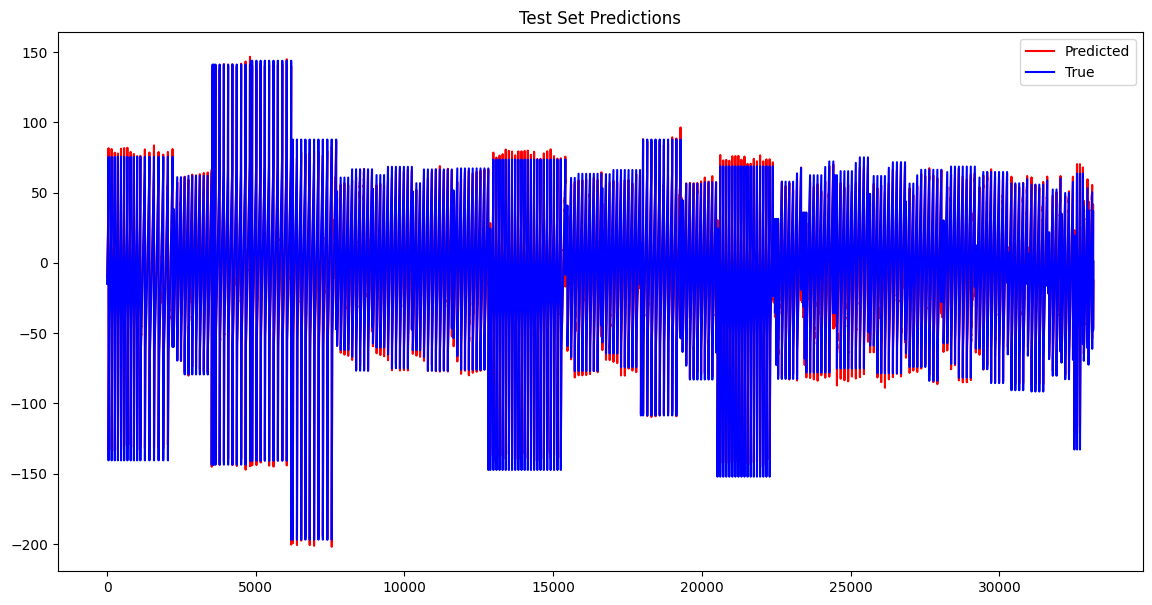

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(predictions, label='Predicted',color = 'red')
plt.plot(y_test, label = "True", color = 'blue')
plt.legend()
plt.title('Test Set Predictions')

The visualization above sufficiently showcases the complexity of the intrinsic value and the model's strong ability to capture the features of the intrinsic value. As the blue curve stands for the ground truth, and the red curve stands for the predictions, we can see that the red curve is very close to the blue curve and two curves largely overlap. This indicates that the model we construct is robust and generalizes well to the test dataset.

We also visualize the train and validation losses, as we need to see if there is any overfitting or underfitting. We first convert each element in two lists storing validation and train losses from torch tensor to numpy array. Then we use matplotlib to draw the plot.

As shown below, the train and validation losses are plotted against the number of epochs. We observe that there is no evidence of overfitting here. Both losses decrease rapidly at the beginning with some fluctuations,but in general they tend to level off, suggesting that the model is learning generalizable patterns.

In [19]:
val_loss_numpy, train_loss_numpy = [],[]
for i in val_loss_list:
    val_loss_numpy.append(i.numpy())
for j in train_loss_list:
    train_loss_numpy.append(j.detach().numpy())

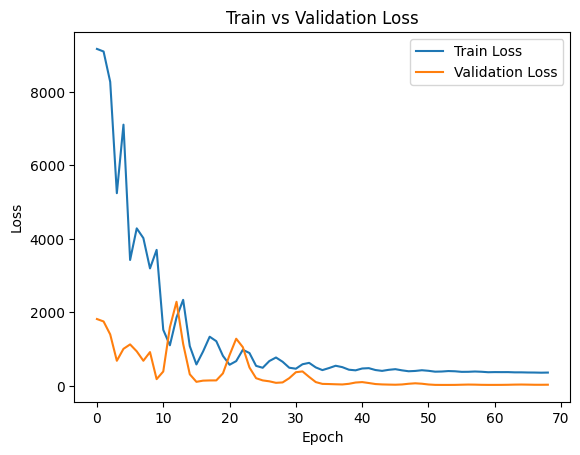

In [20]:

import matplotlib.pyplot as plt
plt.plot(train_loss_numpy, label='Train Loss')
plt.plot(val_loss_numpy, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Train vs Validation Loss")
plt.show()


From our experience with the baseline Linear Regression Model and Autogluon Model, the R2 score drops quickly against time periods, and MSE loss shoots up fast. With the CNN model, we tested both against time as a metric against previous models. The timestamp in these graphs is standardized. 

In [21]:
test_part = y_test.numpy()
# print(len(test_part))
pred_part = predictions.numpy()

# print(len(another))
test_part = pd.DataFrame(test_part)
pred_part = pd.DataFrame(pred_part)

ds_test = ds_new[int(0.9*len(features)):].reset_index(drop=True)

# print(ds_test)
test_part.columns = ['true_intrinsic']
pred_part.columns = ['pred_intrinsic']
together = pd.concat([ds_test, test_part],axis=1)
together = pd.concat([together, pred_part],axis=1)
# print(together)
print(together.columns)

Index(['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]', '[STRIKE]', '[UNDERLYING_LAST]',
       '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', '[C_IV]',
       '[C_VOLUME]', '[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]',
       '[P_VEGA]', '[P_THETA]', '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]',
       '[P_ASK]', 'discounted_price', 'true_intrinsic', 'pred_intrinsic'],
      dtype='object')


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

result_df = together

In [ ]:
plt.xlabel('timestamp')
plt.ylabel('R2 score')
plt.title("R2 score Across Time")
plt.plot(result_df[['[QUOTE_UNIXTIME]', 'true_intrinsic', 'pred_intrinsic']].groupby('[QUOTE_UNIXTIME]').apply(lambda x: metrics.r2_score(x['true_intrinsic'], x['pred_intrinsic'])))
plt.show()

The R2 score trend shown below is kind of turbulent, and in general the R2 score remains stable over time. Also, R2 score has a much better performance than the baseline model as we can see its value never goes below 0.95. 

![R2 score Across Time](o1.png)

In [ ]:
plt.xlabel('timestamp')
plt.ylabel('MSE Loss')
plt.title("MSE Loss Across Time")
plt.plot(result_df[['[QUOTE_UNIXTIME]', 'true_intrinsic', 'pred_intrinsic']].groupby('[QUOTE_UNIXTIME]').apply(lambda x: metrics.mean_squared_error(x['true_intrinsic'], x['pred_intrinsic'])))
plt.show()

THe MSE loss also performs a fluctuating trend, but it is way smaller than the baseline model's MSE loss. So the CNN model is a good choice for the intrinsic value prediction of options and the performance is pretty good. 

[![MSE Loss Across Time](o2.png)

With similar test and train sizes, the CNN model produces much more stable results over extended periods of time than other models. With a rather random and non-Gaussian dataset, this PIC16B level(or beyond) model performs relatively well into the future and can produce better results than traditional machine learning algorithms utilized in PIC16A. 